In [10]:
import torchvision
from torch import Tensor
import numpy as np

from utils import train_vae_classifier
from vae.mnist_vae import  VaeAutoencoderClassifier
from plots import plot_all
from dataset.mnist import prepare_mnist_dataset
from image_classifier.image_classifier import neural_network, train_model, test_model

In [2]:
training_data = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=torchvision.transforms.ToTensor())

input = training_data.data[:60000] / 255.0
labels = training_data.targets[:60000]



In [3]:
vae = VaeAutoencoderClassifier(dim_encoding=2)

vae_classifier_model, total_losses, classifier_accuracy_li, classifier_loss_li, vae_loss_li = train_vae_classifier(
    vae,
    training_data,
    alpha=5000.0,
    epochs=20
)


0 12190.4931640625; 0 11492.091796875; 0 11280.4794921875; 0 11336.1640625; 0 10808.2099609375; 0 11040.3173828125; 0 10760.9921875; 0 11082.2939453125; 0 10753.38671875; 1 10818.2900390625; 1 10587.4072265625; 1 10730.5859375; 1 10960.705078125; 1 10306.9833984375; 1 10692.9140625; 1 10518.33203125; 1 10722.103515625; 1 10436.119140625; 2 10315.9521484375; 2 10329.041015625; 2 10529.7998046875; 2 10747.94921875; 2 10568.6611328125; 2 10611.0703125; 2 10494.5078125; 2 10749.072265625; 2 10533.76171875; 3 10373.875; 3 10433.3662109375; 3 10219.2548828125; 3 10123.58984375; 3 10542.3994140625; 3 10557.953125; 3 10514.1552734375; 3 10296.5546875; 3 10380.470703125; 4 10340.9970703125; 4 10388.265625; 4 10067.708984375; 4 10212.310546875; 4 10585.388671875; 4 10140.2119140625; 4 10298.9521484375; 4 10365.388671875; 4 10666.087890625; 5 10418.693359375; 5 10266.734375; 5 10442.4697265625; 5 10142.1630859375; 5 10609.2568359375; 5 10446.2197265625; 5 10250.0703125; 5 9827.099609375; 5 9991.5

In [22]:
# move tensors to cpu before converting to np array
np_classifier_accuracy_li = []
np_classifier_loss_li = []
np_vae_loss_li = []

for output in classifier_accuracy_li:
    if isinstance(output, Tensor):
        np_classifier_accuracy_li.append(output.cpu().detach().numpy())

for output in classifier_loss_li:
    if isinstance(output, Tensor):
        np_classifier_loss_li.append(output.cpu().detach().numpy())
        
for output in vae_loss_li:
    if isinstance(output, Tensor):
        np_vae_loss_li.append(output.cpu().detach().numpy())

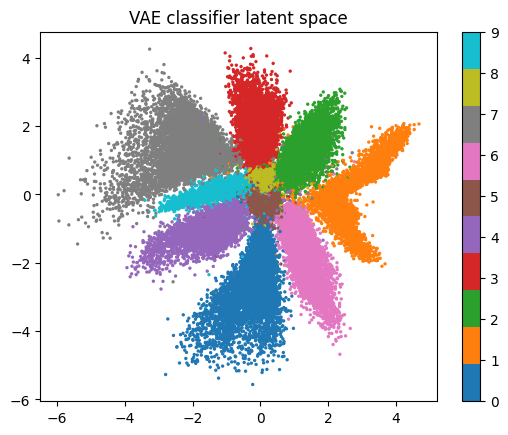

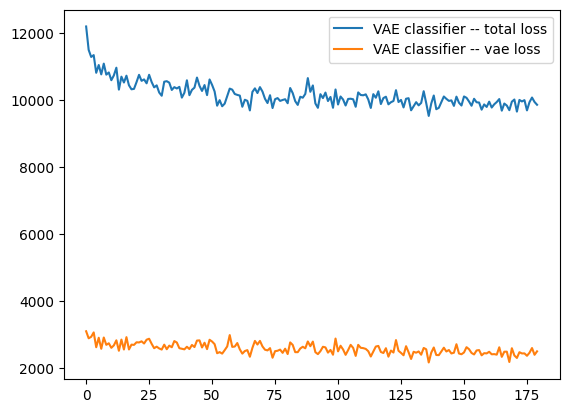

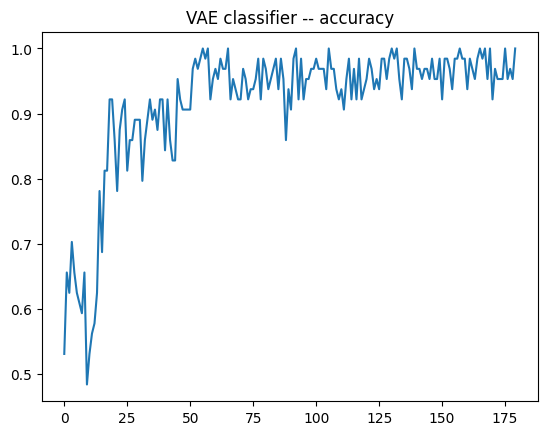

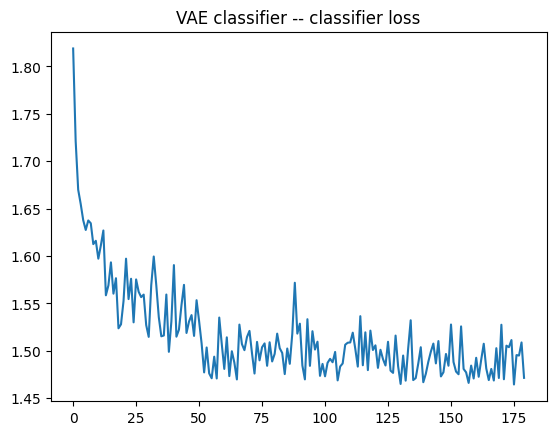

In [24]:
# plot results
plot_all(
    input=input,
    labels=labels,
    vae_model_classifier=vae_classifier_model,
    vae_loss_li=np_vae_loss_li,
    total_losses=total_losses, 
    classifier_accuracy_li=np_classifier_accuracy_li, 
    classifier_loss_li=np_classifier_loss_li, 
)

In [ ]:
# train classifier for performance evaluation

x_train, x_test, y_train, y_test = prepare_mnist_dataset()
nn_model = neural_network(10, 784)
train_model(nn_model, x_train, y_train)
test_model(nn_model, x_test, y_test)

